In [1]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# dataset qui contient les donnees, ie la fonction de courant barotrope
# chemin sur jean-zay : /gpfswork/rech/omr/romr004/MLspinup/IPSLCM6ALR/
MSFTdataset = xr.open_dataset('/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Omon/msftbarot/gn/latest/msftbarot_Omon_IPSL-CM6A-LR_piControl_r1i1p1f1_gn_185001-234912.nc',decode_times=False)
MSFTdataset


<xarray.Dataset>
Dimensions:         (axis_nbounds: 2, nvertex: 4, time: 6000, x: 362, y: 332)
Coordinates:
    nav_lat         (y, x) float32 ...
    nav_lon         (y, x) float32 ...
  * time            (time) float64 15.5 45.0 74.5 ... 1.826e+05 1.826e+05
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_nav_lon  (y, x, nvertex) float32 ...
    bounds_nav_lat  (y, x, nvertex) float32 ...
    area            (y, x) float32 ...
    time_bounds     (time, axis_nbounds) float64 ...
    msftbarot       (time, y, x) float32 ...
Attributes: (12/51)
    name:                   /ccc/work/cont003/dsm/p86maf/IGCM_OUT/IPSLCM6/PRO...
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-04-27T15:00:09Z
    tracking_id:            hdl:21.14100/17e4ba33-4948-4a89-b737-937464656d8d
    description:            DECK: control
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    ...                     ...
    variant_label:          r1i1p1f1
    EXPID:                  piControl
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    dr2xml_md5sum:          00e1a4f623b35a33620b9828c66bd1c8
    model_version:          6.1.2
    history:                Tue Jul 10 16:42:45 2018: ncatted -O -a coordinat...

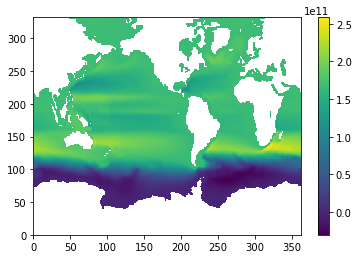

In [5]:
# pour avoir une idee des donnees
#plt.pcolor(MSFTdataset.msftbarot[0,:,:]) # trace un pas de temps, ici le premier
plt.pcolor(np.mean(MSFTdataset.msftbarot,axis=0)) # trace la moyenne temporelle
plt.colorbar()

In [6]:
# dataset qui contient les informations "fixed in time" comme le masque terre / mer et la bathymetrie
MASKdataset = xr.open_dataset('/data/jdeshayes/IPSLCM6ALR/eORCA1.2_mesh_mask.nc',decode_times=False)
MASKdataset

<xarray.Dataset>
Dimensions:       (t: 1, x: 362, y: 332, z: 75)
Dimensions without coordinates: t, x, y, z
Data variables: (12/44)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    time_counter  (t) float64 ...
    tmask         (t, z, y, x) int8 ...
    umask         (t, z, y, x) int8 ...
    ...            ...
    gdepv         (t, z, y, x) float32 ...
    gdepw_0       (t, z, y, x) float32 ...
    gdept_1d      (t, z) float64 ...
    gdepw_1d      (t, z) float64 ...
    e3t_1d        (t, z) float64 ...
    e3w_1d        (t, z) float64 ...
Attributes:
    Conventions:  CF-1.1

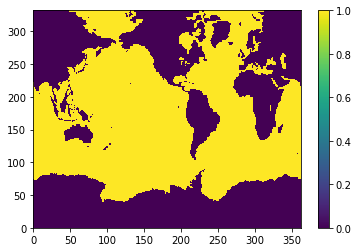

In [8]:
# masque terre (1) et mer (0)
plt.pcolor(MASKdataset.tmask[0,0,:,:])
plt.colorbar()

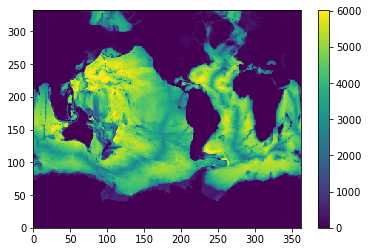

In [9]:
# bathymetrie
plt.pcolor(np.sum(MASKdataset.e3t_0[0,:,:,:]*MASKdataset.tmask[0,:,:],axis=0))
plt.colorbar()

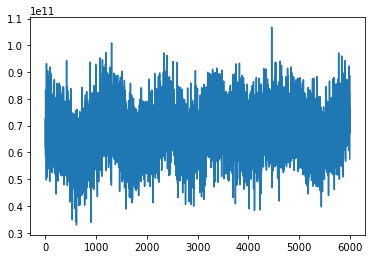

In [10]:
# un exemple de serie temporelle, pour ce dataset 1 pas de temps = 1 mois
plt.plot(MSFTdataset.msftbarot[:,100,100])

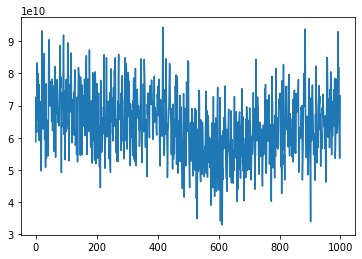

In [11]:
plt.plot(MSFTdataset.msftbarot[0:1000,100,100])

In [82]:
# pour enlever cycle saisonnier moyen des donnees mensuelles
st=np.array(MSFTdataset.msftbarot[:,110,110]) # exemple de serie temporelle mensuelle pendant 1000 ans
st_ssca=st-np.reshape(np.tile(np.mean(np.reshape(st,[500,12]),axis=0),[500,1]),[12*500,]) # serie temporelle sans cycle annuel moyen

In [83]:
# autre solution pour enlever la saisonnalité : on ne travaille qu'avec mois de decembre (serie annuelle)

st_D=np.array(MSFTdataset.msftbarot[11:-1:12,110,110])

# autre solution pour enlever la saisonnalité : on ne travaille qu'avec moyenne des mois DJF (serie annuelle)

st_J=np.array(MSFTdataset.msftbarot[12::12,110,110])
st_F=np.array(MSFTdataset.msftbarot[13::12,110,110])
st_DJF=np.zeros((3,np.size(st_J)))
st_DJF[0,:]=st_D; st_DJF[1,:]=st_J ; st_DJF[2,:]=st_F;
st_DJF=np.mean(st_DJF,axis=0)

(499,)

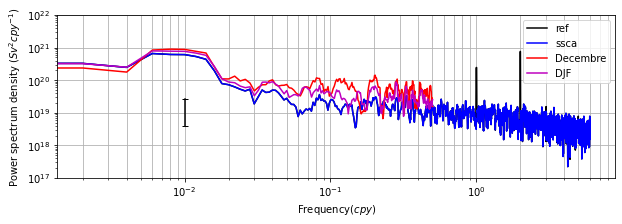

In [104]:
# comparaison du spectre des differentes series
from envtoolkit import spectral
figure = plt.figure(figsize=(10,3))
ax = plt.gca()
nbandw = 3
deltat = 86400*365/12
ferror = 1e-2

[spectrum, freq, error] = spectral.multitaper((st - np.mean(st)), nbandw=nbandw)
freq = freq*365*86400/deltat    # to get the result in cpy
spectrum = spectrum/(365*86400/deltat)    # to get the result in cpy^{-1}
error = error/(365*86400/deltat)    # to get the result in cpy^{-1}
barmax = error[0, 0]*1e0
barmin = error[1, 0]*1e0
plt.plot(freq, spectrum,color='k',linestyle='solid',label='ref')
plt.plot([ferror, ferror], [barmin*1e20, barmax*1e20], marker='_', color='k')

[spectrum, freq, error] = spectral.multitaper(st_ssca, nbandw=nbandw)
freq = freq*365*86400/deltat    # to get the result in cpy
spectrum = spectrum/(365*86400/deltat)    # to get the result in cpy^{-1}
plt.plot(freq, spectrum,color='b',linestyle='solid',label='ssca')

deltat = 86400*365
[spectrum, freq, error] = spectral.multitaper(st_D-np.mean(st_D), nbandw=nbandw)
freq = freq*365*86400/deltat    # to get the result in cpy
spectrum = spectrum/(365*86400/deltat)    # to get the result in cpy^{-1}
plt.plot(freq, spectrum,color='r',linestyle='solid',label='Decembre')

[spectrum, freq, error] = spectral.multitaper(st_DJF-np.mean(st_DJF), nbandw=nbandw)
freq = freq*365*86400/deltat    # to get the result in cpy
spectrum = spectrum/(365*86400/deltat)    # to get the result in cpy^{-1}
plt.plot(freq, spectrum,color='m',linestyle='solid',label='DJF')

plt.grid(True, which='both', axis='x')
plt.grid(True, which='major', axis='y')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
ax.set_ylim([1e17,1e22])
ax.set_ylabel("Power spectrum density ($Sv^2 cpy^{-1}$)")
ax.set_xlabel("Frequency($cpy$)")
plt.legend()
figure.savefig('/data/jdeshayes/IPSLCM6ALR/IPSLCM6ALR_msftbarot_test_sp.png')